<table> 
    <tr>
        <td  style="background-color:#ffffff;"><a href="https://qsoftware.lu.lv/index.php/qworld/" target="_blank"><img src="..\Images\qworld.jpg" width="70%" align="left"></a></td>
        <td style="background-color:#ffffff;" width="*"></td>
        <td  style="background-color:#ffffff;vertical-align:text-top;"><a href="https://qsoftware.lu.lv" target="_blank"><img src="..\Images\qturkey.png" width="50%" align="right"></a></td>        
    </tr></table>
<table><tr style="background-color:white;">
    <td>Follow Us (QWorld)</td>
    <td><a href="https://www.facebook.com/qworld19/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QWorld19" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QLatvia</td>
    <td><a href="https://www.facebook.com/QLatviaSoftware/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QLatviaSoftware" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QTurkey</td>
    <td><a href="https://www.facebook.com/groups/290363815207623/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/KuantumTurkiye" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    </tr></table>

## Ensemble Methods -- Boosting
https://pennylane.ai/qml/demos/tutorial_ensemble_multi_qpu.html

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import sklearn.datasets
import sklearn.decomposition
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
n_features = 2
n_classes = 3
n_samples = 150

data = sklearn.datasets.load_iris()
x = data["data"]
y = data["target"]

In [3]:
np.random.seed(1967)
x, y = zip(*np.random.permutation(list(zip(x, y))))

pca = sklearn.decomposition.PCA(n_components=n_features)
pca.fit(x)
x = pca.transform(x)

In [4]:
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)

x = 2 * np.pi * (x - x_min) / (x_max - x_min) - np.pi

In [5]:
split = 125

x_train = x[:split]
x_test = x[split:]
y_train = y[:split]
y_test = y[split:]

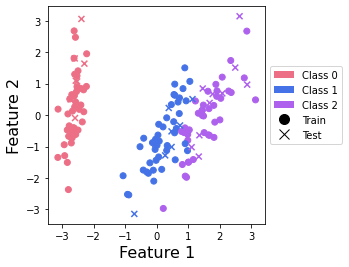

In [6]:
colours = ["#ec6f86", "#4573e7", "#ad61ed"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])

    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train, y_train, x_test, y_test)

In [18]:
n_wires = 4

dev0 = qml.device("forest.qpu", device="Aspen-4-4Q-F")
dev1 = qml.device("qiskit.aer", wires=4)
devs = [dev0, dev1]

/home/ayshine/anaconda3/envs/QML/lib/python3.7/site-packages/pyquil/api/_compiler.py:242: UserWarning: No quilc server reachable at tcp://127.0.0.1:5555. Compilation using quilc will not be available.
  warnings.warn(f"{e}. Compilation using quilc will not be available.")


In [19]:
def circuit0(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[1, 0, i], wires=i)

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[3, 0])

    for i in range(n_wires):
        qml.Rot(*params[1, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))


def circuit1(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[0, 0, i], wires=i)

    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[1, 3])

    for i in range(n_wires):
        qml.Rot(*params[0, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

In [20]:
def decision(softmax):
    return int(torch.argmax(softmax))


def predict_point(params, x_point=None, parallel=True):
    results = qnodes(params, x=x_point, parallel=parallel)
    softmax = torch.nn.functional.softmax(results, dim=1)
    choice = torch.where(softmax == torch.max(softmax))[0][0]
    chosen_softmax = softmax[choice]
    return decision(chosen_softmax), decision(softmax[0]), decision(softmax[1]), int(choice)

In [21]:
qnodes = qml.QNodeCollection(
    [qml.QNode(circuit0, dev0, interface="torch"),
     qml.QNode(circuit1, dev1, interface="torch")]
)

In [22]:
def predict(params, x=None, parallel=True):
    predictions_ensemble = []
    predictions_0 = []
    predictions_1 = []
    choices = []

    for i, x_point in enumerate(x):
        if i % 10 == 0 and i > 0:
            print("Completed up to iteration {}".format(i))
        results = predict_point(params, x_point=x_point, parallel=parallel)
        predictions_ensemble.append(results[0])
        predictions_0.append(results[1])
        predictions_1.append(results[2])
        choices.append(results[3])

    return predictions_ensemble, predictions_0, predictions_1, choices

In [23]:
params = np.load("../data/ensemble_multi_qpu/params.npy")

In [24]:
print("Predicting on training dataset")
p_train, p_train_0, p_train_1, choices_train = predict(params, x=x_train)
print("Predicting on test dataset")
p_test, p_test_0, p_test_1, choices_test = predict(params, x=x_test)

Predicting on training dataset


QuilcNotRunning: No quilc server reachable at tcp://127.0.0.1:5555